In [31]:
#IMPORT DELLE LIBRERIE
import numpy as np 
import os
import tarfile
import numpy as np
import matplotlib.pyplot as plt
import zipfile

import cv2
import os
import glob
import gc

import skimage.transform as trans
from skimage import io, color
from skimage.util import random_noise

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras

from sklearn.datasets import fetch_lfw_people
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [32]:
#DOWNLOAD DEL DATASET
!mkdir data_faces && wget https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip 

mkdir: cannot create directory ‘data_faces’: File exists


In [33]:
#UNZIP DEL DATASET
with zipfile.ZipFile("celeba.zip","r") as zip_ref:
  zip_ref.extractall("data_faces/")

In [34]:
#FUNZIONE PER CARICARE IN MEMORIA LE IMMAGINI
def read_images(img_dir, xdim, ydim, nmax=50000) :
    label = 0
    label_names = []
    X = []
    y=[]
    for dirname in os.listdir(img_dir):
        print(dirname)
        label_names.append(dirname)
        data_path = os.path.join(img_dir + "/" + dirname,'*g')
        files = glob.glob(data_path)
        n=0
        for f1 in files:
            if n>=nmax : break
            img = cv2.imread(f1) 
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
            img = cv2.resize(img, (xdim,ydim))
            X.append(np.array(img)) 
            n=n+1
        print(n,' images lues')
    X = np.array(X)
    gc.collect() 
    return X

In [70]:
#CARICO IN MEMORIA 100000 IMMAGINI
X= read_images("data_faces", 64, 64, 100000)

img_align_celeba
100000  images lues


In [71]:
#SPLIT DEL DATASET PER IL TEST SET
X_train, X_test = train_test_split(X,
    test_size=0.2)

#SPLIT DEL DATASET PER IL VALIDATION SET
X_train, X_val = train_test_split(X_train, 
    test_size=0.1)

#MODIFICA DI COME VENGONO SALVATE LE IMMAGINI IN MEMORIA
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
X_val = X_val.astype('float32') / 255

In [72]:
#DIMENSIONI DEL TRAINING SET
X_train.shape

(72000, 64, 64, 3)

In [73]:
#DIMENSIONI DEL TEST SET
X_test.shape

(20000, 64, 64, 3)

In [74]:
#DIMENSIONI DEL VALIDATION SET
X_val.shape

(8000, 64, 64, 3)

In [75]:
X_train_1=X_train[36000:]
X_train_2=X_train[:36000]

In [76]:
#AGGIUNGIAMO IL RUMORE ALLE IMMAGINI DEL TRAINING SET
noise_factor = 0.2

X_train_1_noisy = random_noise(X_train_1, mode="s&p",clip=True, amount=noise_factor)
X_train_2_noisy = random_noise(X_train_2, mode="s&p",clip=True, amount=noise_factor)
X_train_noisy=np.concatenate((X_train_2_noisy, X_train_1_noisy), axis=0)

In [77]:
#PULIZIA MEMORIA
X_train_1=np.delete
X_train_2=np.delete
X_train_1_noisy=np.delete
X_train_2_noisy=np.delete

In [78]:
#AGGIUNGIAMO IL RUMORE ALLE IMMAGINI DEL TEST SET E DEL VALIDATION SET
X_test_noisy = random_noise(X_test, mode="s&p",clip=True, amount=noise_factor)
X_val_noisy = random_noise(X_val, mode="s&p",clip=True, amount=noise_factor)

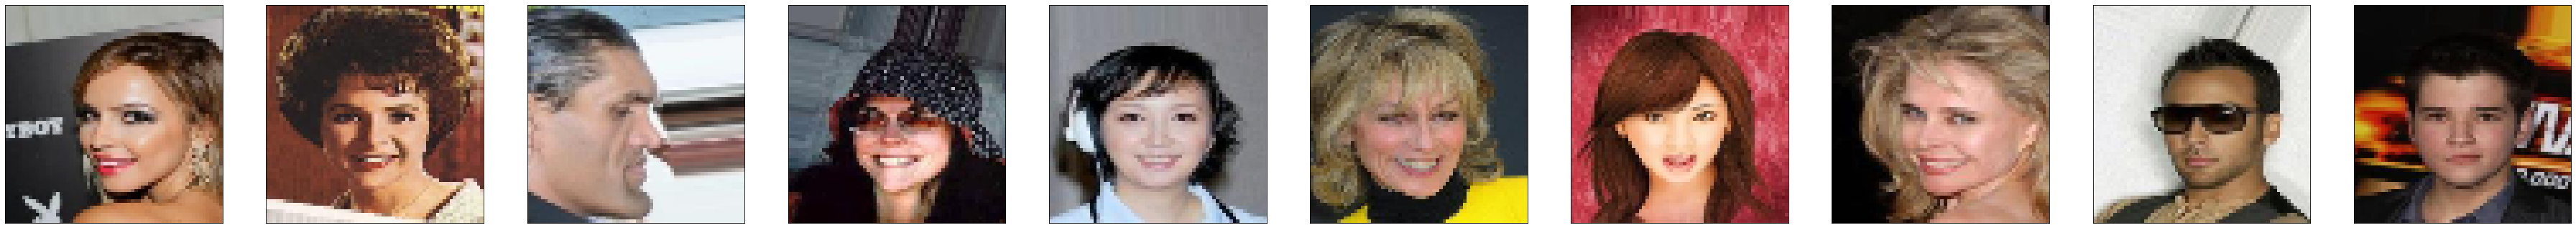

In [44]:
#STAMPO LE PRIME DIECI IMMAGINI DEL TRAINING SET
n = 10

plt.figure(figsize=(64, 64))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(X_train[i].reshape(64, 64,3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

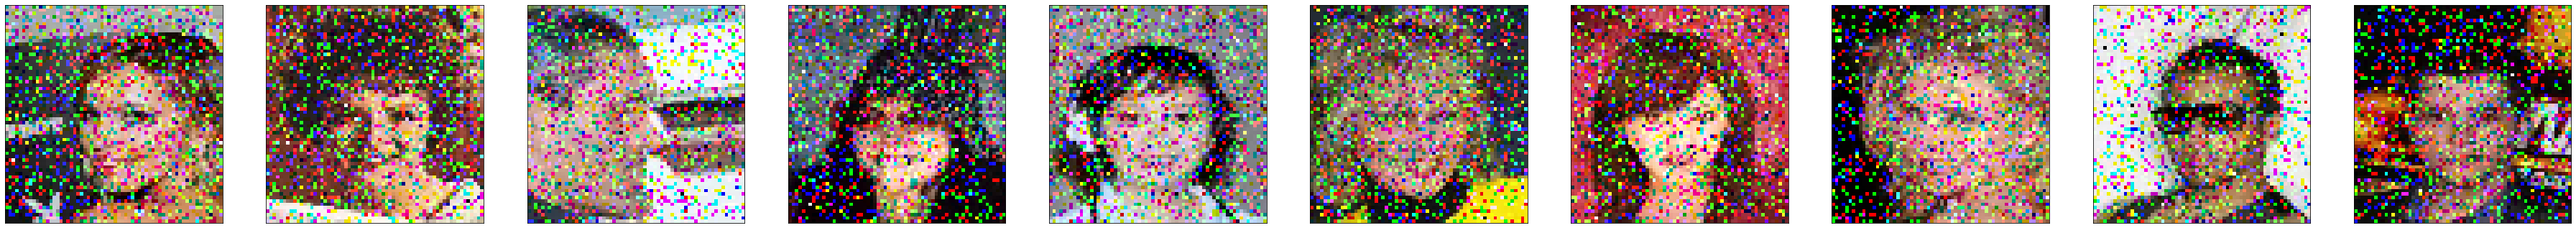

In [45]:
#STAMPO LE PRIME DIECI IMMAGINI DEL TRAINING SET COL RUMORE
n = 10

plt.figure(figsize=(64, 64))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(X_train_noisy[i].reshape(64, 64,3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [46]:
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose,\
                                    GlobalAveragePooling2D, AveragePooling2D, MaxPool2D, UpSampling2D,\
                                    BatchNormalization, Activation, ReLU, Flatten, Dense, Input,\
                                    Add, Multiply, Concatenate, Softmax
from tensorflow.keras import initializers, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import softmax

tf.keras.backend.set_image_data_format('channels_last')
import keras.backend as K

In [47]:
class Conv_block(tf.keras.layers.Layer):
    def  __init__(self, num_filters=200, kernel_size=3, **kwargs):
        super().__init__(**kwargs)
        self.num_filters=num_filters
        self.kernel_size=kernel_size
        self.conv_1 = Conv2D(filters=self.num_filters, kernel_size=self.kernel_size, padding='same')
        self.conv_2 = Conv2D(filters=self.num_filters, kernel_size=self.kernel_size, padding='same')
        self.conv_3 = Conv2D(filters=self.num_filters, kernel_size=self.kernel_size, padding='same')
        self.conv_4 = Conv2D(filters=self.num_filters, kernel_size=self.kernel_size, padding='same')

        self.bn_1 = BatchNormalization()
        self.bn_2 = BatchNormalization()
        self.bn_3 = BatchNormalization()
        self.bn_4 = BatchNormalization()
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'num_filters': self.num_filters,
            'kernel_size':self.kernel_size
        })
        return config

    def call(self, X):
        X = self.conv_1(X)
        # X = self.bn_1(X)
        X = ReLU()(X)
        X = self.conv_2(X)
        # X = self.bn_2(X)
        X = ReLU()(X)
        X = self.conv_3(X)
        # X = self.bn_3(X)
        X = ReLU()(X)
        # X = self.conv_4(X)
        # # X = self.bn_4(X)
        # X = ReLU()(X)

        return X

In [48]:
class DWT_downsampling(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    def call(self, x):
        """
        The following calculations for DWT are inspired from,
        https://github.com/AureliePeng/Keras-WaveletTransform/blob/master/models/DWT.py
        """
        x1 = x[:, 0::2, 0::2, :] #x(2i−1, 2j−1)
        x2 = x[:, 1::2, 0::2, :] #x(2i, 2j-1)
        x3 = x[:, 0::2, 1::2, :] #x(2i−1, 2j)
        x4 = x[:, 1::2, 1::2, :] #x(2i, 2j)   

        x_LL = x1 + x2 + x3 + x4
        x_LH = -x1 - x3 + x2 + x4
        x_HL = -x1 + x3 - x2 + x4
        x_HH = x1 - x3 - x2 + x4

        return Concatenate(axis=-1)([x_LL, x_LH, x_HL, x_HH])

In [49]:
class IWT_upsampling(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    def call(self, x):
        x_LL = x[:, :, :, 0:x.shape[3]//4]
        x_LH = x[:, :, :, x.shape[3]//4:x.shape[3]//4*2]
        x_HL = x[:, :, :, x.shape[3]//4*2:x.shape[3]//4*3]
        x_HH = x[:, :, :, x.shape[3]//4*3:]

        x1 = (x_LL - x_LH - x_HL + x_HH)/4
        x2 = (x_LL - x_LH + x_HL - x_HH)/4
        x3 = (x_LL + x_LH - x_HL - x_HH)/4
        x4 = (x_LL + x_LH + x_HL + x_HH)/4 

        y1 = K.stack([x1,x3], axis=2)
        y2 = K.stack([x2,x4], axis=2)
        shape = K.shape(x)
        return K.reshape(K.concatenate([y1,y2], axis=-1), K.stack([shape[0], shape[1]*2, shape[2]*2, shape[3]//4]))


In [50]:
def create_model():
    tf.keras.backend.clear_session()

    input = Input(shape=(64,64,3))

    cb_1 = Conv_block(num_filters=64)(input)
    dwt_1 = DWT_downsampling()(cb_1)

    cb_2 = Conv_block(num_filters=128)(dwt_1)
    dwt_2 = DWT_downsampling()(cb_2)

    cb_3 = Conv_block(num_filters=256)(dwt_2)
    dwt_3 = DWT_downsampling()(cb_3)

    cb_4 = Conv_block(num_filters=512)(dwt_3)
    dwt_4 = DWT_downsampling()(cb_4)

    cb_5 = Conv_block(num_filters=512)(dwt_4)
    cb_5 = BatchNormalization()(cb_5)
    cb_5 = Conv_block(num_filters=512)(cb_5)
    cb_5 = Conv2D(filters=2048, kernel_size=3, strides=1, padding='same')(cb_5)

    up = IWT_upsampling()(cb_5)
    up = Conv_block(num_filters=512)(Add()([up, cb_4]))
    up = Conv2D(filters=1024, kernel_size=3, strides=1, padding='same')(up)

    up = IWT_upsampling()(up)
    up = Conv_block(num_filters=256)(Add()([up, cb_3]))
    up = Conv2D(filters=512, kernel_size=3, strides=1, padding='same')(up)
    
    up = IWT_upsampling()(up)
    up = Conv_block(num_filters=128)(Add()([up, cb_2]))
    up = Conv2D(filters=256, kernel_size=3, strides=1, padding='same')(up)
    
    up = IWT_upsampling()(up)
    up = Conv_block(num_filters=64)(Add()([up, cb_1]))
    up = Conv2D(filters=128, kernel_size=3, strides=1, padding='same')(up)

    out = Conv2D(filters=3, kernel_size=(1, 1), padding="same")(up)

    return Model(inputs=[input], outputs=[out])

model = create_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv_block (Conv_block)        (None, 64, 64, 64)   75648       ['input_1[0][0]']                
                                                                                                  
 dwt_downsampling (DWT_downsamp  (None, 32, 32, 256)  0          ['conv_block[0][0]']             
 ling)                                                                                            
                                                                                                  
 conv_block_1 (Conv_block)      (None, 32, 32, 128)  590208      ['dwt_downsampling[0][0]']   

In [51]:
model.compile(optimizer = Adam(lr = 1e-4), loss = 'mse')

In [52]:
#TRAINING DEL MODELLO
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.001, patience=1)
history = model.fit(X_train_noisy, X_train, epochs=100, batch_size=16, validation_data=(X_val_noisy,X_val), callbacks=[callback])

Epoch 1/100
3375/3375 [==============================] - 505s 146ms/step - loss: 0.3488 - val_loss: 0.0039
Epoch 2/100
3375/3375 [==============================] - 493s 146ms/step - loss: 0.0028 - val_loss: 0.0021
Epoch 3/100
3375/3375 [==============================] - 493s 146ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 4/100
3375/3375 [==============================] - 493s 146ms/step - loss: 0.0011 - val_loss: 7.6497e-04


In [61]:
#TEST DEL MODELLO SUL TEST SET
predict = model.predict(X_test_noisy)

469/469 [==============================] - 30s 63ms/step


In [ ]:
predict.shape

In [55]:
n=10

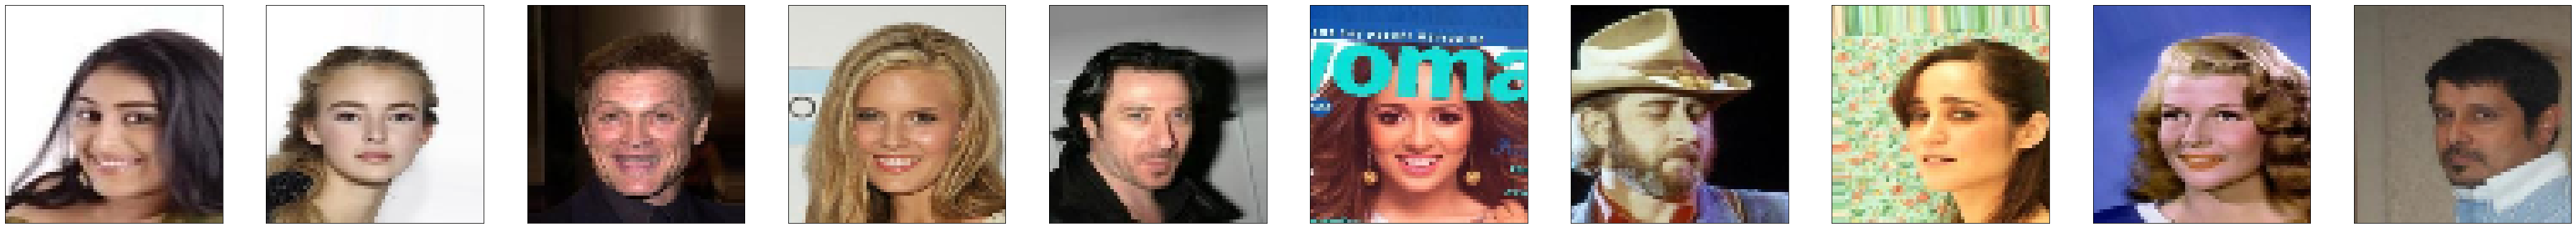

In [56]:
#STAMPO LE PRIME DIECI IMMAGINI DEL TEST SET
plt.figure(figsize=(64, 64))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(X_test[i].reshape(64, 64,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

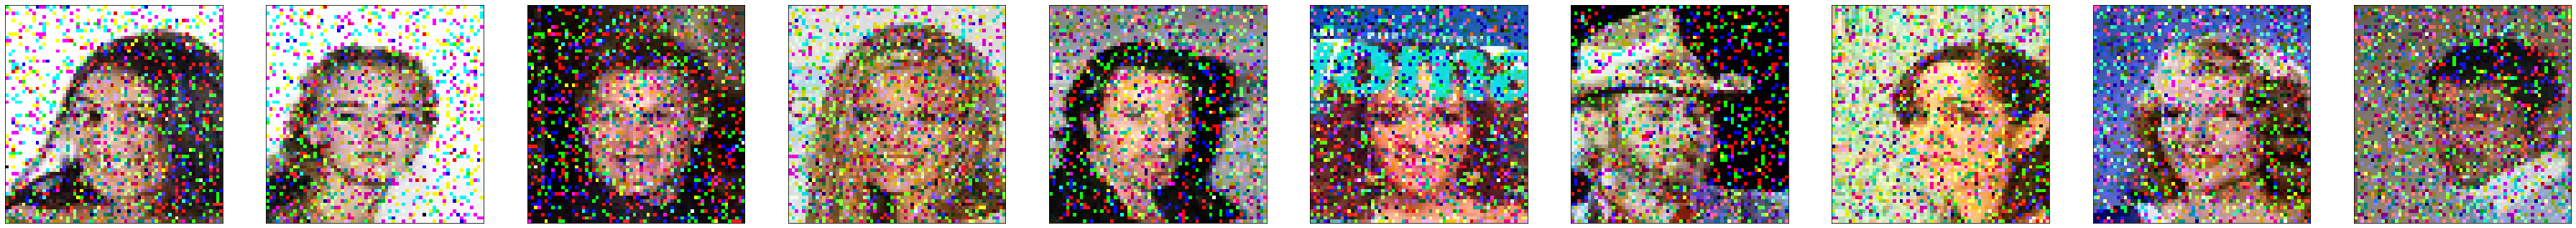

In [57]:
#STAMPO LE PRIME DIECI IMMAGINI DEL TEST SET COL RUMORE
plt.figure(figsize=(64, 64))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(X_test_noisy[i].reshape(64, 64,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

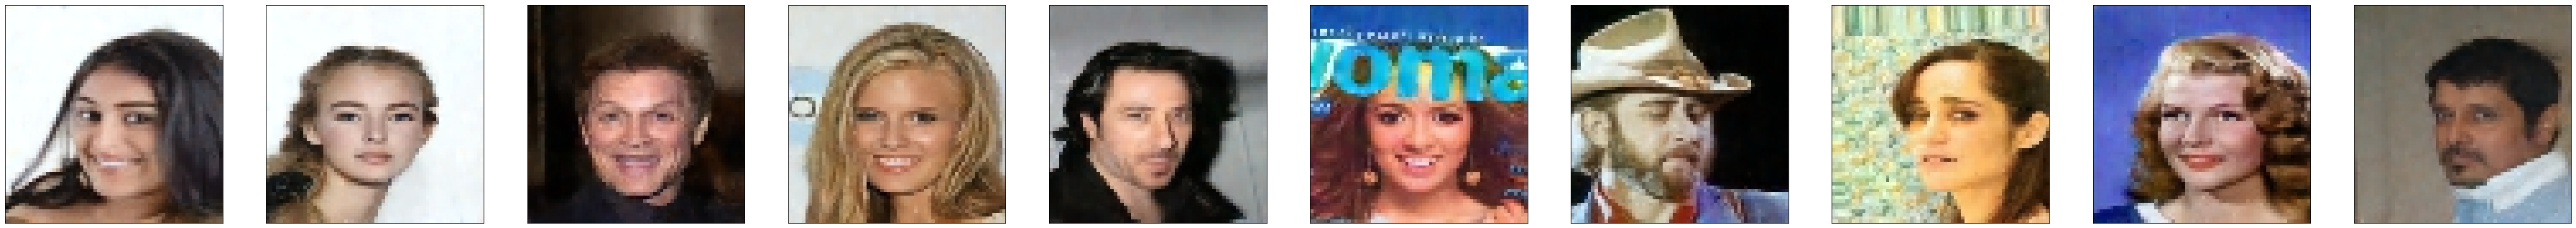

In [58]:
#STAMPO LE PRIME DIECI IMMAGINI DEL TEST SET SENZA RUMORE (OUTPUT DELLA UNET)
plt.figure(figsize=(64, 64))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(predict[i].reshape(64, 64,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [68]:
NUMBER_OF_TEST_IMAGES = len(X_test)

mse = mean_squared_error(X_test.reshape(NUMBER_OF_TEST_IMAGES, 64*64*3), predict.reshape(NUMBER_OF_TEST_IMAGES, 64*64*3))
mae = mean_absolute_error(X_test.reshape(NUMBER_OF_TEST_IMAGES, 64*64*3), predict.reshape(NUMBER_OF_TEST_IMAGES, 64*64*3))
rmse = np.sqrt(mean_squared_error(X_test.reshape(NUMBER_OF_TEST_IMAGES, 64*64*3), predict.reshape(NUMBER_OF_TEST_IMAGES, 64*64*3)))

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("Root Mean Squared Error:", rmse)

Mean Squared Error: 0.00076695625
Mean Absolute Error: 0.018713443
Root Mean Squared Error: 0.027693976


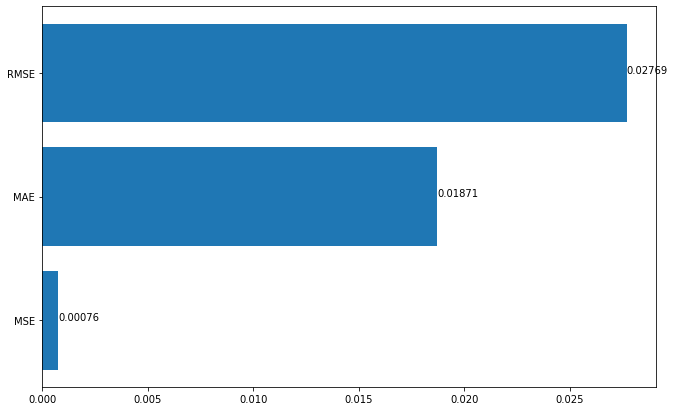

In [69]:
plt.figure(figsize = (11,7))
x = ["MSE","MAE","RMSE"]
y = [mse,mae,rmse]
plt.barh(x, y)
  
for index, value in enumerate(y):
    plt.text(value, index,
             str(value)[:7])
plt.show()